## Modules

In [1]:
# Modules
import sys
sys.path.append("/home/simon/Documents/REPO/Exact_laws")
sys.path.append("/home/simon/Documents/REPO/Simu/Rapport_simu_exactlaw/notebook")

from exact_laws.preprocessing.process_on_standard_h5_file import describ_file
from visualisation_tools import *
from exact_laws.mathematical_tools.derivation import cdiff

import os
from matplotlib import ticker, rc
from matplotlib import gridspec
import numpy as np
import json

In [38]:
# Matplotlib config
%matplotlib widget
#%matplotlib qt5
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('font', size=18)

numfig = 0

/tmp/ipykernel_87379/696745916.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


## Informations et données

In [3]:
simu_name = 'LF2'
with open("/home/simon/Documents/REPO/Simu/descript_oca_simu.json","r") as f:
    simus = json.load(f)[simu_name]
#del(simus['10600'],simus['12500'],simus['12785'],simus['12800'],simus['12815'],)
times = list(simus.keys())
for t in times : 
    if not '6580' in t: del(simus[t])
times = list(simus.keys())
simus_name= 'LF2'
print(simus[times[0]])

{'original_folder': '/home/simon/Documents/DATA/SIMULATIONS/OCA/data_simus_oca/LF2/LF2_6540-6550-6560-6570-6580/', 'cycle': 'cycle_4', 'group_grid': 'Simulation_Parameters', 'N': [512, 512, 512], 'kdi': 0.045454545454545456, 'theta': 1.3090118039723961, 'thrsh_forc_hi': 0.016, 'thrsh_forc_lo': 0.015, 'a1_forc': 0.5, 'act_forc': None, 'nu': 7.35e-08, 'eta': 7.35e-08, 'hdiss_rho': 0, 'hdiss_p': 7.35e-09, 'an_hd': 1, 'ap0': 1, 'B0': [0, 0, 1], 'beta0': 1, 'name': 'LF2.6580', 'EL_red1D': ['/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/LF2.6580/OCA_LF2.6580_alli_EL_lincart_all_red1D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/LF2.6580/OCA_LF2.6580_alleq_EL_lincart_all_red1D.h5'], 'EL_red2D': ['/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/LF2.6580/OCA_LF2.6580_alli_EL_lincart_all_red2D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/LF2.6580/OCA_LF2.6580_alleq_EL_lincart_all_red2D.h5']}


In [4]:
# Paths 
path_record_images = f"./images_{simu_name}/"
if not os.path.exists(path_record_images) : os.mkdir(path_record_images)

In [5]:
# Paramètres
simu = f"{simu_name}"
kdi = simus[times[0]]['kdi'] # kperpdi = 2pidi/l => l/di = 2pi/(kdi)
theta = simus[times[0]]['theta']
lforc = np.array([(2*np.pi/kdi, 2*np.pi/kdi*np.tan(theta)),(2*np.pi/kdi/np.sqrt(2), 2*np.pi/kdi*np.tan(theta))]) # (lperp/di, lpar/di)
linert = (1,1)
print(lforc)

[[138.23007676 515.91234557]
 [ 97.74342464 515.91234557]]


In [6]:
# Grille
grid = read_grid_in_h5file(simus[times[0]]['EL_red2D'][0])
c = grid['c']
axe_par = np.array(grid['lpar'])*grid['c'][2]
axe_perp = np.array(grid['lperp'])#*grid['c'][0]
label_par = "$\ell_{\parallel} / d_i$"
label_perp = "$\ell_{\perp}/ d_i$"
del(grid)
grid = read_grid_in_h5file(simus[times[0]]['EL_red1D'][0])
axe_l = np.array(grid['l'])
label_l = "$\ell / d_i$"
print(axe_par[1],axe_par[2],max(axe_par))
print(axe_perp[1],axe_perp[2],max(axe_perp))
print(axe_l[1],max(axe_l))

1.00764129994632 2.01528259989264 256.9485314863116
0.2699806186678728 0.5399612373357456 68.84505776030757
0.2699806186678728 68.84505776030757


In [7]:
gridlp, gridlpar = np.meshgrid(axe_perp,axe_par, indexing='ij')
filt_45 = np.arctan(gridlpar/np.where(gridlp==0,1e-19,gridlp))*180/np.pi
filt_45inf = np.where(filt_45<=45,1,np.nan)
filt_45sup = np.where(filt_45>=45,1,np.nan)
filt_45b = np.arctan(gridlpar/np.where(gridlp==0,1e-19,gridlp))
filt_45binf = np.where(filt_45b<=theta,1,np.nan)
filt_45bsup = np.where(filt_45b>=theta,1,np.nan)
filt_perp10pc = np.where(gridlp<=lforc[1,0]*0.1,1,np.nan)
filt_par10pc = np.where(gridlpar<=lforc[1,1]*0.1,1,np.nan)
del(gridlp,gridlpar)

## Lecture et assemblage de lois exactes

In [13]:
# Lecture fichiers et corrections
dict_quantities = {}
dict_quantities1D = {}
dict_coeffs = {}
quantities = {} 
quantities1D = {}  
coeffs = {}

for it,t in enumerate(simus.keys()):
    dict_quantities[t] = {}
    dict_coeffs[t] = {}
    for fstr in simus[t]['EL_red2D']:
        dqs, _, dcs = readfile(fstr)
        for k in dqs.keys():
            dict_quantities[t][k] = dqs[k] 
            if "ue" in k and not 'uegyr' in k and not 'cor' in k:
                dict_quantities[t][k] = dqs[k.replace('ue','uegyr')] 
        for k in dcs.keys():
            dict_coeffs[t][k] = dcs[k]
            if "source_rbdd" in k:
                dict_coeffs[t][k] = -np.abs(dcs[k])
            #if "ue" in k and not 'uegyr' in k:
                #dict_coeffs[t][k] = dcs[k]*1836
                #del(dict_coeffs[t][k])
            # if k.startswith("SS22Elec") and 'j' in k or 'rbdd' in k : 
            #     dict_coeffs[t]['H'+k] = dict_coeffs[t][k]
            #     del(dict_coeffs[t][k])
    
    dict_quantities1D[t] = {}
    for fstr in simus[t]['EL_red1D']:
        dqs, _, dcs = readfile(fstr)
        for k in dqs.keys():
            dict_quantities1D[t][k] = dqs[k] 
for q in dict_quantities[times[-1]].keys():
    quantities[q] = np.mean(np.array([dict_quantities[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_quantities1D[times[-1]].keys():
    quantities1D[q] = np.mean(np.array([dict_quantities1D[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_coeffs[times[-1]].keys():
    coeffs[q] = dict_coeffs[times[-1]][q]


In [64]:
# Combinaisons de termes
dic_of_list_terms = {}
dic_of_list_terms['ELhall'] = [k for k in coeffs if k.startswith('Hallcor')]
dic_of_list_terms['ELhcglions'] = [k for k in coeffs if k.startswith('SS22Gyr')]+ dic_of_list_terms['ELhall']
dic_of_list_terms['ELhisoions'] = [k for k in coeffs if k.startswith('SS22Iso')]+ dic_of_list_terms['ELhall']
dic_of_list_terms['ELelecisonh']  =  [k for k in coeffs if k.startswith('SS22Elec') and not 'j' in k and not 'rbdd' in k]
dic_of_list_terms['ELhiso'] = dic_of_list_terms['ELelecisonh'] + dic_of_list_terms['ELhisoions']
dic_of_list_terms['ELhisoecgli'] = dic_of_list_terms['ELelecisonh'] + dic_of_list_terms['ELhcglions']
dic_of_list_terms['ELeleccglnh']  =  [k for k in coeffs if k.startswith('SS22ElecGyr') and not 'j' in k and not 'rbdd' in k]
dic_of_list_terms['ELhcglecgli'] = dic_of_list_terms['ELeleccglnh'] + dic_of_list_terms['ELhcglions']

dic_of_list_terms['ELeleciso']  =  [k for k in coeffs if k.startswith('SS22Elec')]
dic_of_list_terms['ELhcglisoep'] =dic_of_list_terms['ELhcglions']  + dic_of_list_terms['ELeleciso']

dic_of_list_terms['ELeleccgl']  =  [k for k in coeffs if 'SS22ElecGyr' in k ] 
dic_of_list_terms['ELhcglep'] = dic_of_list_terms['ELhcglions'] + dic_of_list_terms['ELeleccgl']

dic_of_list_terms['ELheat']  =  [k for k in coeffs if k.startswith('SS22Heat')]
dic_of_list_terms['EL'] = dic_of_list_terms['ELhcglep'] + dic_of_list_terms['ELheat']

dic_of_list_terms['ELhpe']  =  [k for k in coeffs if 'SS22ElecGyr' in k and 'j' in k or 'rbdd' in k]
print(dic_of_list_terms['ELhpe'] )


['SS22ElecGyr_div_flux_drduegyrdj', 'SS22ElecGyr_source_rbddpean', 'SS22ElecGyr_source_rbddpeperp', 'SS22ElecGyr_source_rduegyrdj', 'SS22ElecGyr_source_rpeandj', 'SS22ElecGyr_source_rpeperpdj', 'SS22Elec_source_rbddpe']


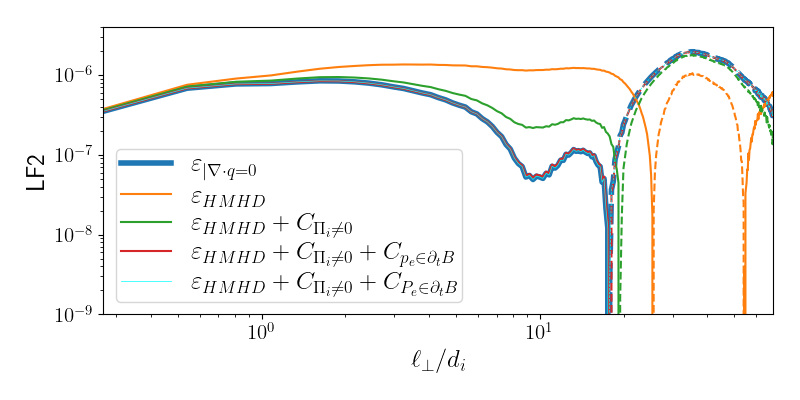

In [70]:
plt.figure('M1', figsize=(8,4))
plt.clf()

y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELhcglep'])
splot(axe_perp[1:],np.nanmean((y2)*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{|{\\nabla \cdot q = 0}}$',linewidth=4)

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELhiso']) 
splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{HMHD}$')

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELhcglecgli']) 
splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{HMHD} + C_{\Pi_i \\neq 0}$')

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELhcglisoep']) 
splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{HMHD} + C_{\Pi_i \\neq 0} + C_{p_e \in \partial_t B}$')

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELhcglep']) 
splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],color='cyan',linewidth=0.5,label = '$\\varepsilon_{HMHD} + C_{\Pi_i \\neq 0} + C_{P_e \in \partial_t B}$')


#splot(axe_perp[1:],np.nanmean((y2-y1)*filt_45binf,axis=1)[1:],label = '$C_{\Pi_i}$')

# y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['EL'])
# splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{CGLt}$')


plt.xscale('log')
plt.yscale('log')
plt.xlim(axe_perp[1],axe_perp[-1])
plt.ylim(1e-9,4e-6)
plt.ylabel('LF2')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=1,loc='lower left',columnspacing=0.5,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

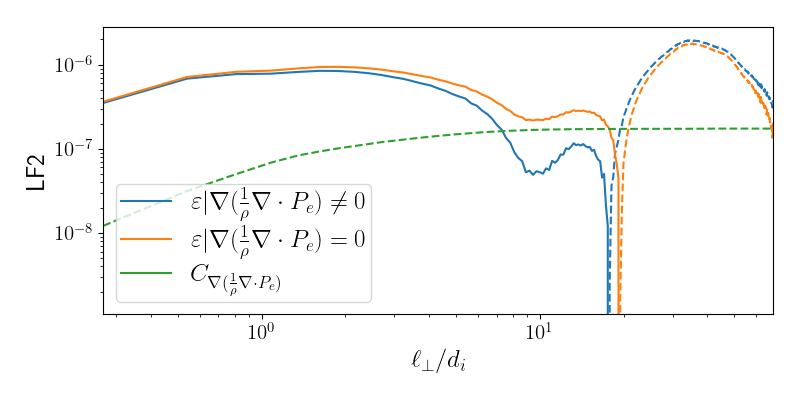

In [58]:
plt.figure('M1', figsize=(8,4))
plt.clf()

y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELhcglep'])
splot(axe_perp[1:],np.nanmean((y2)*filt_45binf,axis=1)[1:],label = '$\\varepsilon|\\nabla ( \\frac{1}{\\rho} \\nabla \cdot P_e ) \\neq 0$')

y1 = y2 - linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELhpe']) 
splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon|\\nabla ( \\frac{1}{\\rho} \\nabla \cdot P_e ) = 0$')


splot(axe_perp[1:],np.nanmean((y2-y1)*filt_45binf,axis=1)[1:],label = '$C_{\\nabla ( \\frac{1}{\\rho} \\nabla \cdot P_e )}$')

# y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['EL'])
# splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{CGLt}$')


plt.xscale('log')
plt.yscale('log')
plt.xlim(axe_perp[1],axe_perp[-1])
#plt.ylim(1e-11,1e-5)
plt.ylabel('LF2')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=1,loc='lower left',columnspacing=0.5,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

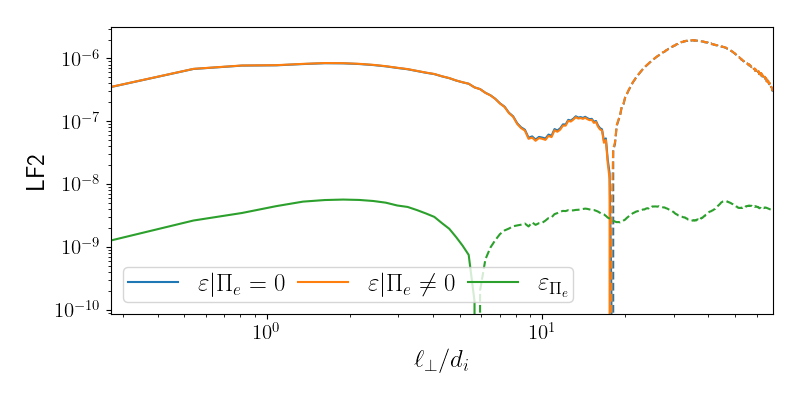

In [46]:
plt.figure('M2', figsize=(8,4))
plt.clf()

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELhcgl'])
splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon|\Pi_e = 0$')

y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELhcglep'])
splot(axe_perp[1:],np.nanmean((y2)*filt_45binf,axis=1)[1:],label = '$\\varepsilon|\Pi_e \\neq 0$')

splot(axe_perp[1:],np.nanmean((y2-y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{\Pi_e}$')

# y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['EL'])
# splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{CGLt}$')


plt.xscale('log')
plt.yscale('log')
plt.xlim(axe_perp[1],axe_perp[-1])
#plt.ylim(1e-11,1e-5)
plt.ylabel('LF2')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.5,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

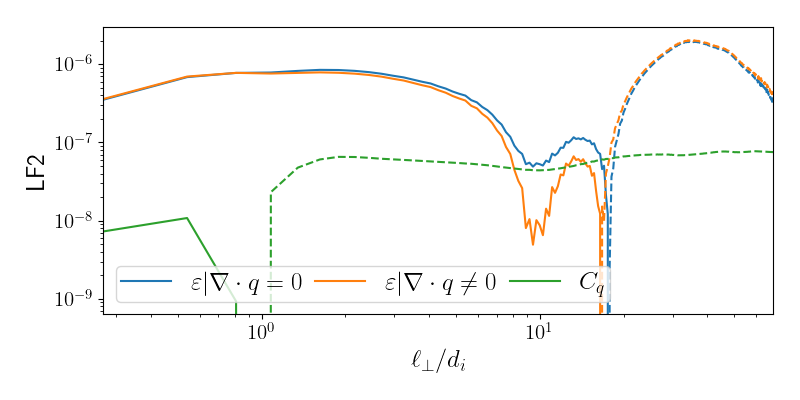

In [45]:
plt.figure('M3', figsize=(8,4))
plt.clf()

y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELhcglep'])
splot(axe_perp[1:],np.nanmean((y2)*filt_45binf,axis=1)[1:],label = '$\\varepsilon|{\\nabla \cdot q = 0}$')

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['EL'])
splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],label = '$\\varepsilon|{\\nabla \cdot q \\neq 0}$')

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELheat'])
splot(axe_perp[1:],np.nanmean((y1)*filt_45binf,axis=1)[1:],label = '$C_{q}$')

plt.xscale('log')
plt.yscale('log')
plt.xlim(axe_perp[1],axe_perp[-1])
#plt.ylim(1e-11,1e-5)
plt.ylabel('LF2')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.5,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

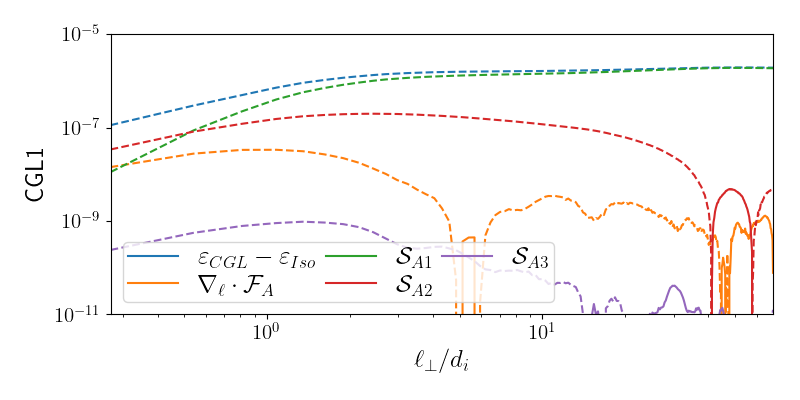

In [16]:
plt.figure('M2', figsize=(8,4))
plt.clf()

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['EL'])
y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELIso'])
splot(axe_perp[1:],np.nanmean((y1-y2)*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{CGL}-\\varepsilon_{Iso}$') 

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELcgl_flux'])
y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELiso_flux'])
splot(axe_perp[1:],np.nanmean((y1-y2)*filt_45binf,axis=1)[1:],label = '$\\nabla_{\\ell} \cdot \\mathbf{\mathcal{F}}_{A}$') 

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELcgl_sdv'])
y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELiso_sdv'])
splot(axe_perp[1:],np.nanmean((y1-y2)*filt_45binf,axis=1)[1:],label = '$\mathcal{S}_{A1}$') 

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELcgl_sdp'])
y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELiso_sdp'])
splot(axe_perp[1:],np.nanmean((y1-y2)*filt_45binf,axis=1)[1:],label = '$\mathcal{S}_{A2}$') 

y1 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELcgl_sdr'])
y2 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['ELiso_sdr'])
splot(axe_perp[1:],np.nanmean((y1-y2)*filt_45binf,axis=1)[1:],label = '$\mathcal{S}_{A3}$') 

plt.xscale('log')
plt.yscale('log')
plt.xlim(axe_perp[1],axe_perp[-1])
plt.ylim(1e-11,1e-5)
plt.ylabel('CGL1')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

/tmp/ipykernel_87379/4243889190.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()
/tmp/ipykernel_87379/4243889190.py:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()
/tmp/ipykernel_87379/4243889190.py:30: RuntimeWarning: Mean of empty slice
  subsplot(ax0, axe_par[1:], np.nanmean(ELcgl*filt_45bsup, axis=0)
/tmp/ipykernel_87379/4243889190.py:32: RuntimeWarning: Mean of empty slice
  subsplot(ax0, axe_par[1:], np.nanmean(ELiso*filt_45bsup, axis=0)
/tmp/ipykernel_87379/4243889190.py:34: RuntimeWarning: Mean of empty slice
  subsplot(ax0, axe_par[1:], np.nanmean((ELcgl-ELiso)*filt_45bsup, axis=0)[1:],


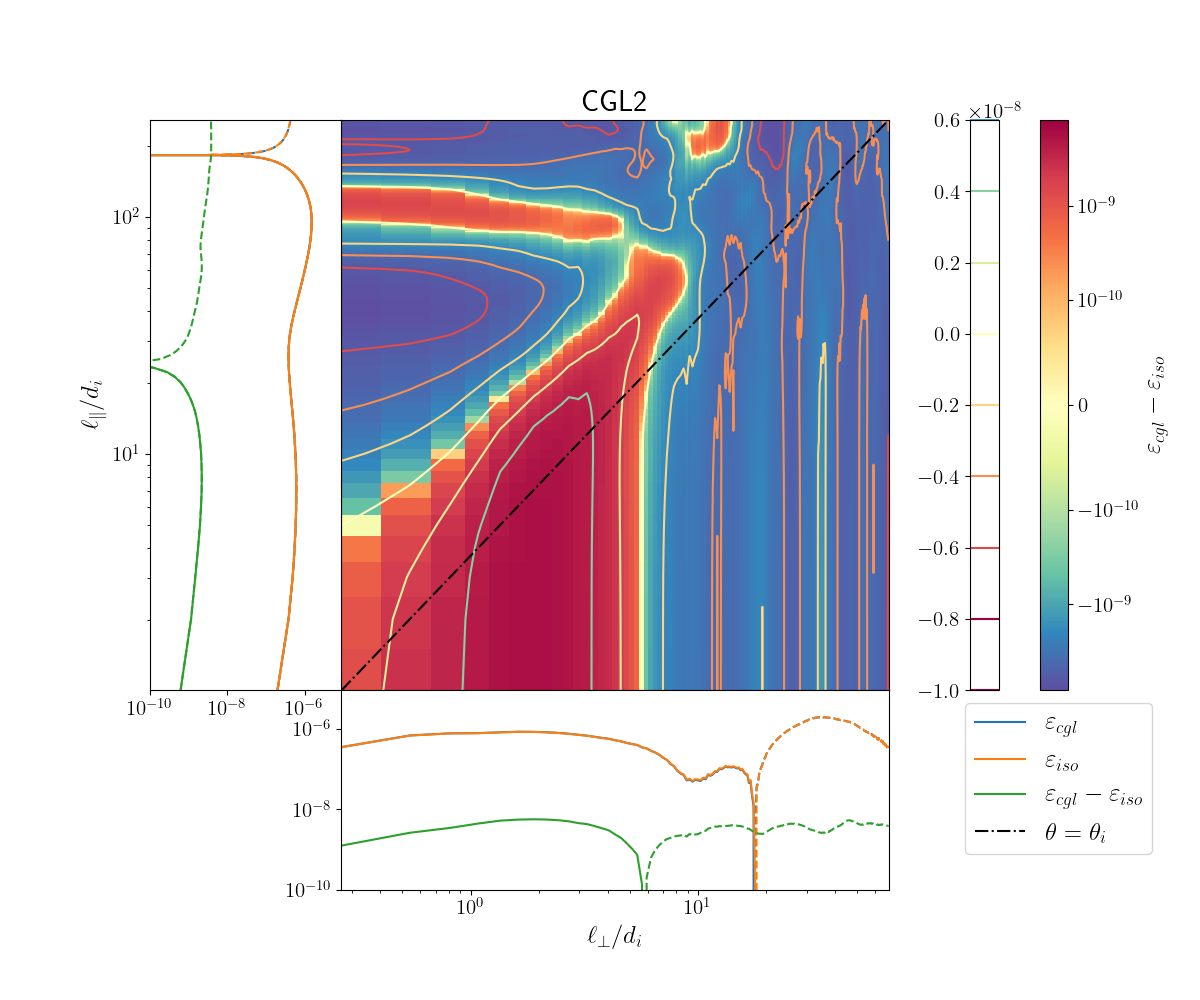

In [21]:
X, Y = np.meshgrid(axe_perp, axe_par)
ELcgl = linear_op_from_list_term(coeffs, quantities, dic_of_list_terms['ELhcglep'])
ELiso = linear_op_from_list_term(coeffs, quantities, dic_of_list_terms['ELhcgl'])
Z = (ELcgl-ELiso)

fig = plt.figure('M5', figsize=(12, 10))
plt.clf()

spec = gridspec.GridSpec(ncols=3, nrows=2,
                         width_ratios=[0.7, 2, 0.7], wspace=0,
                         hspace=0, height_ratios=[2, 0.7])


ax1 = plt.subplot(spec[1])
ax1.set_title('CGL2')
colormap = ax1.pcolor(X, Y, np.transpose(Z), norm=colors.SymLogNorm(linthresh=1e-10, vmin=- np.max(np.abs(Z)), vmax=np.max(np.abs(Z))),
                      cmap='Spectral_r', shading='auto')

contours = ax1.contour(X, Y, np.transpose(
    Z), 7, cmap='Spectral', vmin=- np.max(np.abs(Z)), vmax=np.max(np.abs(Z)))

ax1.plot(axe_perp[1:], axe_perp[1:]*np.tan(theta),
         'k-.', label='$\\theta = \\theta_i$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(axe_perp[1], axe_perp[-1])
ax1.set_ylim(axe_par[1], axe_par[-1])

ax0 = plt.subplot(spec[0], sharey=ax1)
subsplot(ax0, axe_par[1:], np.nanmean(ELcgl*filt_45bsup, axis=0)
         [1:], label='$\\varepsilon_{cgl}$', orientation='inverse')
subsplot(ax0, axe_par[1:], np.nanmean(ELiso*filt_45bsup, axis=0)
         [1:], label='$\\varepsilon_{iso}$', orientation='inverse')
subsplot(ax0, axe_par[1:], np.nanmean((ELcgl-ELiso)*filt_45bsup, axis=0)[1:],
         label='$\\varepsilon_{cgl} - \\varepsilon_{iso}$', orientation='inverse')
ax0.plot([2, 4], [4, 5], 'k-.', label='$\\theta = \\theta_i$')

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(1e-10,9e-6)
ax0.set_ylabel('$\ell_{\\parallel}/d_i$')

ax4 = plt.subplot(spec[4], sharex=ax1)
subsplot(ax4, axe_perp[1:], np.nanmean(
    ELcgl*filt_45binf, axis=1)[1:], label='$\\varepsilon_{cgl}$')
subsplot(ax4, axe_perp[1:], np.nanmean(
    ELiso*filt_45binf, axis=1)[1:], label='$\\varepsilon_{iso}$')
subsplot(ax4, axe_perp[1:], np.nanmean((ELcgl-ELiso)*filt_45binf,
         axis=1)[1:], label='$\\varepsilon_{cgl} - \\varepsilon_{iso}$')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_ylim(1e-10,9e-6)
ax4.set_xlabel('$\ell_{\\perp}/d_i$')

ax2 = plt.subplot(spec[2])
ax2.axis('off')

cbar = fig.colorbar(contours, ax=[ax2, ], location='left', anchor=(
    0.5, 0), pad=0.5, fraction=1,)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar2 = fig.colorbar(colormap, ax=[ax2, ], location='right',
                     label='$\\varepsilon_{cgl} - \\varepsilon_{iso}$', anchor=(-0.6, 0), fraction=1)

ax0.legend(bbox_to_anchor=(5.3, 0))
plt.show()